# Introduction to Data Science

Propomos utilizar **Polaridade-Subjetividade**, junto a **Presença-Ausência** de um conjunto de temas em cada Tweet como parte dos preditores; junto a isso, a **Contagem Diária**, **Contagem de Retweets**, **Contagem de Favoritos**, **Data e Horário**, **Presença de Mídias ou Citações**, por exemplo.

Propomos ainda usar um fator de retardo $k$ para caracterizar a influencia retardada das postagens. Caso o ajuste significativo ocorra sob um fator $k \neq 0$, isto é, caso alterções relevantes sejam observadas após as postagens, e com coeficientes significativos, podemos discutir a influencia dos tweets como possível; caso o retardo seja nulo, ou pequeno, podemos discutir a exiestencia de correlação sem causalidade.

Ao tratar de séries temporais envolvendo dados financeiros, comumente tratamos a ifluencia de preditores sobre a variação relativa do dados; para isso buscamos predizer os *log-retornos* das variáveis econômicas escolhidas.

**Referencias Utilizadas**:
  * **Constantin Colonescu**. The Effects of Donald Trump’s Tweets on US Financial and Foreign Exchange Markets. Athens Journal of Business and Economics. Disponível em: www.athensjournals.gr/business/2018-1-X-Y-Colonescu.pdf

In [230]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns

import statsmodels.api as sm
from statsmodels.api import OLS

import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

from datetime import datetime
from datetime import timedelta
import statsmodels.api as sm

%matplotlib inline

## Preparação dos dados

Inclui as etapas de standandização, separação, e agregação segundo diferentes métodos: sob certas hipóteses, podemos agregar os tweets diários pela média, sentimentos extremos, tweet mais curtido ou repostado. Isto é: agregamos diariamente os tweets sob certo método. Considerar o tweet mais repostado, por exemplo, faz sentido sob a suposção de que este será o mais relevante do dia.

In [231]:
# read the data
tweets_data = pd.read_pickle("data/final_tweets_data.pkl")
tweets_data = tweets_data.drop(["full_text", "full_text_en"], axis=1)
economic_data = pd.read_csv("data/economic_time_series.csv", sep=";", index_col=0)

Usamos um formato padrão de datas e ajustamos as séries temporais.

In [232]:
# use standard date format "datetime"
economic_data.index = pd.to_datetime(economic_data.index)

tweets_data["date"]  = tweets_data.year.apply(str) + "-"
tweets_data["date"] += tweets_data.month.apply(str) + "-"
tweets_data["date"] += tweets_data.day.apply(str)
tweets_data["date"]  = pd.to_datetime(tweets_data["date"])

Para primeira análise, agregamos alguns dados com relação ao tweet mais favoritado, tomando por hipótese que este será o mais relevante naquele dia. Adicionamos, ainda, novas tabelas agragando o total de retweets do dia, assim como polaridade e subjetividade médias, por exemplo: 

In [233]:
# agragate by most favorited tweet
agg_indexes = []

for group_key, group in tweets_data.groupby("date", as_index=True):
  most_favorited = group[group["favorite_count"] == group["favorite_count"].max()]
  most_favorited = most_favorited.sample(n=1)
  agg_indexes = np.append(agg_indexes, most_favorited.index)

most_favorited = tweets_data.iloc[agg_indexes]
most_favorited = most_favorited.set_index("date")

# agragate by dayly mean
dayly_agg_columns = ["date","retweet_count","favorite_count","polarity","subjectivity"]
dayly_agregated = tweets_data[dayly_agg_columns].groupby("date", as_index=False).mean()

dayly_agregated.columns = [col + "_mean" for col in dayly_agg_columns]
dayly_agregated = dayly_agregated.set_index("date_mean")

# put aggregated data together
tweets_dayly = pd.concat([most_favorited, dayly_agregated], axis=1)

Adicionamos algumas *dummy-variables* convertendo um conjunto de variáveis qualitativas dos preditores em colunas numéricas.

In [234]:
# select by data type wich to be made dummy
cols_to_strd = ["user_mentions", "hashtags"]
cols_to_dumm = ["media_type", "name", "topic", "weekday",
                "year", "month", "day", "hour", "minute"]

# add dummies 
for col in cols_to_dumm:
  dummies = pd.get_dummies(tweets_dayly[col], prefix=col, drop_first=True)
  tweets_dayly = pd.concat([tweets_dayly.drop(col, axis=1), dummies], axis=1)

for col in cols_to_strd:
  dummies = tweets_dayly[col].str.get_dummies("/").add_prefix(col)
  tweets_dayly = pd.concat([tweets_dayly.drop(col, axis=1), dummies], axis=1)

Tornamos os Dados Economicos no formato de log-retornos; esse formato é útil quando estamos interesados no estudo da variação de dados econômicos, por se mostrar uma variável relativa. Isso significa que deve ser possível observar impactos.

In [235]:
# pick the economic data at same range as tweet data
min = tweets_data["date"].min()
max = tweets_data["date"].max()

dt_day = timedelta(days=1)
economic_data = economic_data[economic_data.index >= min - dt_day]
economic_data = economic_data[economic_data.index <= max]

# put the data into log-return format
economic_data_lr  = np.log(1 + economic_data.pct_change())

Finalmente, separamos os dados de treino e teste em 20%-80% do total. Por simplicidade, renomeamos os dados para DT_train, DT_test (DT - Dayly Tweets). Para primeira apresentação, buscamos regredir um simples modelo para o Ibovespa, por ser índice mais volátil e conhecido; posteriormente, as mesmas tecnicas apresentadas serão utilizadas na discussão dos demais dados.

Para uso em modelo com retardo, adicionamos um novo índice linear, mais facilmente iterável.

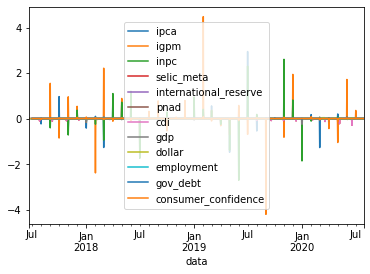

In [249]:
# put data together
economic_data_lr.plot()

## Visualizing the data

## Ajuste de Modelos, Regularização e *Cross-Validation*

## Significância dos Coeficientes 

## Discussão dos Coeficientes e Modelo

## Resultados